In [1]:
# load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
%matplotlib inline

from skimage.measure import compare_ssim
from sklearn.model_selection import train_test_split

# load required functionality from keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, AveragePooling2D
from keras.models import Model
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Add, Subtract
from keras.callbacks import ModelCheckpoint, EarlyStopping, History 
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as keras_backend


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
keras_backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12778041933733343806
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6602251960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1488432400362769531
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
"""
    Peak Signal-to-Noise Ratio:
         > 40dB: great
        30~40dB: good
        20~30dB: bad
         < 20dB: worse
"""
def PSNR(y_true, y_pred):
    return -10. * np.log10(np.mean(np.square(y_pred - y_true)))

def SSIM(img1, img2, _range=None):
    return compare_ssim(img1, img2, data_range=_range)

def printHistory(history): 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [3]:
"""
    basic CNN model
"""
def SRCNN(pretrained_weights=None):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu',input_shape=(512, 512, 1),padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(1, (3, 3), activation='relu', padding="same"))

    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    if(pretrained_weights):
            model.load_weights(pretrained_weights)

    return model

In [4]:
"""
    load validation data
"""
import gc

dataY = np.zeros((500,512, 512))

count = 0
for i in range(1, 101):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_valid_gray/" + picture + ".png", cv2.IMREAD_GRAYSCALE)
    dataY[count] = img
    dataY[count+1] = img
    dataY[count+2] = img
    dataY[count+3] = img
    dataY[count+4] = img
    count += 5
                 
dataY = dataY.reshape(-1, 512, 512, 1)
dataY = dataY.astype('float32') / 255

In [5]:
"""
    noise image
"""
X = np.zeros((500,512, 512))
count = 0
for i in range(1, 101):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_valid_gray_out/" + picture + "_out50.png", cv2.IMREAD_GRAYSCALE)
    X[count] = img
    img = cv2.imread("../../div2k_valid_gray_out/" + picture + "_out60.png", cv2.IMREAD_GRAYSCALE)
    X[count+1] = img
    img = cv2.imread("../../div2k_valid_gray_out/" + picture + "_out70.png", cv2.IMREAD_GRAYSCALE)
    X[count+2] = img
    img = cv2.imread("../../div2k_valid_gray_out/" + picture + "_out80.png", cv2.IMREAD_GRAYSCALE)
    X[count+3] = img
    img = cv2.imread("../../div2k_valid_gray_out/" + picture + "_out90.png", cv2.IMREAD_GRAYSCALE)
    X[count+4] = img
    count += 5

X = X.reshape(-1, 512, 512, 1)
X = X.astype('float32') / 255

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== GanAndMse valid ==
loss: 0.00184038376621902
accuracy: 0

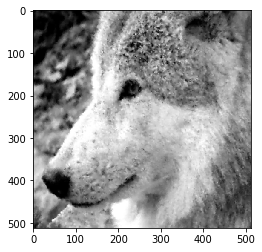

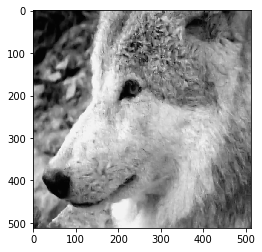

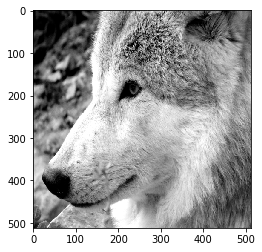

25.529260635375977
29.27829726934433
0.7118845254137111
0.8765126292834838


In [6]:
model = SRCNN("./gan5/_generator_200000.h5")
print("== GanAndMse valid ==")
X = X.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X)
result = result.reshape(-1, 512, 512)
X = X.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X[24]
plt.imshow(img, cmap="gray")
plt.show()

img = result[24]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[24]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[24], result[24]) )

totalPSNR = 0
for i in range(500):
    totalPSNR += PSNR(dataY[i], result[i])
    #print(i+1, PSNR(dataY[i], result[i]))
print(totalPSNR/500)
                 
totalSSIM = 0
for i in range(500): 
    totalSSIM += SSIM(dataY[i], result[i], 1.0) #0.5114699011236234
print(SSIM(dataY[24], result[24], 1.0))
print(totalSSIM/500)

count = 0
for i in range(100):
    img = result[count]
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    cv2.imwrite("../../Denoise_2K_afterGAUSS_GanAndMse_0.3/" + str(i+1) + '_denoise50.bmp', img)
    img = result[count+1]
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    cv2.imwrite("../../Denoise_2K_afterGAUSS_GanAndMse_0.3/" + str(i+1) + '_denoise60.bmp', img)
    img = result[count+2]
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    cv2.imwrite("../../Denoise_2K_afterGAUSS_GanAndMse_0.3/" + str(i+1) + '_denoise70.bmp', img)
    img = result[count+3]
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    cv2.imwrite("../../Denoise_2K_afterGAUSS_GanAndMse_0.3/" + str(i+1) + '_denoise80.bmp', img)
    img = result[count+4]
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    cv2.imwrite("../../Denoise_2K_afterGAUSS_GanAndMse_0.3/" + str(i+1) + '_denoise90.bmp', img)
    count+=5